#Load necessary libraries

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Mount google drive

In [ ]:
#The dataset used in this project is stored on my google drive hence I'm using the below library to allow colab to access my drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Navigate to the required directory
crop_weed_data_path = '/content/drive/My Drive/crop_weed_data'
os.chdir(crop_weed_data_path)

#List the folders in the directory
os.listdir()

['ann', 'img', 'C:']

#Extract and create a dataframe containing the filenames and its corresponding labels.

In [ ]:
import json
import pandas as pd
import os

"""
This script processes image and annotation data for crop and weed classification.

The first step is to extract and create separate variables for the image paths and annotation path.
Then, two separate lists are created to store the filenames and labels after extracting them by iterating over the paths.
Finally, a dataframe is created using the extracted data for better accessibility.
"""

# Create separate paths for images and annotations
img_path = os.path.join(crop_weed_data_path, 'img')
ann_path = os.path.join(crop_weed_data_path, 'ann')

# Initialize empty lists to store image filenames and labels
filenames = []
labels = []

# Loop through the annotations folder to get every annotation and store it in labels
for ann_file in os.listdir(ann_path):
    if ann_file.endswith('.json'):
        # Construct the full path to the annotation file
        labels_path = os.path.join(ann_path, ann_file)

        try:
            # Load the JSON file
            with open(labels_path, 'r') as f:
                annotations = json.load(f)

                # Extract the filename from the JSON file
                filename = ann_file.replace('.json', '')

                # Extract the labels from the JSON file
                if annotations['objects']:
                    label = annotations['objects'][0]['classTitle']

                    # Assign the labels as binary labels
                    if label == 'crop':
                        label = 1
                    else:
                        label = 0

                    # Append the filename and label to their respective lists
                    filenames.append(filename)
                    labels.append(label)
                else:
                    # If there are no objects in the JSON, skip the file
                    print(f"No objects found in {ann_file}")

        except Exception as e:
            print(f"Error reading {ann_file}: {e}")

# Create a DataFrame from these lists
crop_weed_data = pd.DataFrame({'Filename': filenames, 'Labels': labels})
crop_weed_data.head()


,Filename,Labels
0,agri_0_3374.jpeg,0
1,agri_0_3471.jpeg,1
2,agri_0_347.jpeg,0
3,agri_0_326.jpeg,1
4,agri_0_3468.jpeg,1


#Load and preprocess images

In [ ]:
# Print filenames from the annotations DataFrame
print(crop_weed_data['Filename'].head())

0    agri_0_3374.jpeg
1    agri_0_3471.jpeg
2     agri_0_347.jpeg
3     agri_0_326.jpeg
4    agri_0_3468.jpeg
Name: Filename, dtype: object


#List all the missing filenames

In [ ]:
#Initialize an empty list to store all the missing filenames
missing_files = []

#Iterate through the Filename column in the DataFrame and extract the missing filenames and append it to the list accordingly
for filename in crop_weed_data['Filename']:
    img_file_path = os.path.join(img_path, filename)
    if not os.path.exists(img_file_path):
        missing_files.append(filename)

#Print the list of missing filenames
if missing_files:
    print(f"Missing files: {missing_files}")
else:
    print("All files are present.")


Missing files: ['agri_0_3569 (1).jpeg']


#Define a function to load the images and preprocess them.

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(df, img_path, target_size=(256, 256)):
    """
    Load and preprocess images from the specified directory based on filenames in a DataFrame.

    This function reads image files from a given directory, resizes them to the specified target size,
    and converts them to numpy arrays. It also handles missing files and reports any errors encountered
    during loading.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the filenames of the images to be loaded.
    img_path (str): Path to the directory where the images are stored.
    target_size (tuple): Target size for resizing images (default is (256, 256)).

    Returns:
    numpy.ndarray: Array of loaded and preprocessed images.

    Prints:
    - Errors encountered during image loading.
    - List of missing files.
    """
    images = []
    missing_files = []
    for filename in df['Filename']:
        img_file_path = os.path.join(img_path, filename)
        if os.path.exists(img_file_path):
            try:
                img = load_img(img_file_path, target_size=target_size)
                img_array = img_to_array(img)
                images.append(img_array)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            missing_files.append(filename)
    if missing_files:
        print(f"Missing files: {missing_files}")
    return np.array(images)

#Remove missing files from dataframe

In [ ]:
# Filter out the missing files
crop_weed_data = crop_weed_data[~crop_weed_data['Filename'].isin(missing_files)]

# Reset the index
crop_weed_data.reset_index(drop=True, inplace=True)

#Split data into X and y

In [ ]:
# Load images
X = load_images(crop_weed_data, img_path)

# Normalize the images
X = X / 255.0

# Get the labels from the created DataFrame
y = np.array(crop_weed_data['Labels'])

In [ ]:
X.shape

(1300, 256, 256, 3)

In [ ]:
y.shape

(1300,)

#Splitting data into train and test

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 1040
Validation set size: 260


# **Crop and Weed classification using CNN model**

#Model building

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#Define and create the CNN model
cnn_model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape=(256,256,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid') #We use sigmoid as it is a binary classification
])

In [ ]:
#Compile the model created
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#Model training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

#Define early stopping by providing parameter values accordingly
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

#Train the model on 10 epochs
cnn_history = cnn_model.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val), callbacks = [early_stopping])

Epoch 1/10
33/33 [==============================] - 12s 149ms/step - loss: 1.5966 - accuracy: 0.6510 - val_loss: 0.4118 - val_accuracy: 0.8500
Epoch 2/10
33/33 [==============================] - 2s 73ms/step - loss: 0.4072 - accuracy: 0.8365 - val_loss: 0.3693 - val_accuracy: 0.8462
Epoch 3/10
33/33 [==============================] - 2s 67ms/step - loss: 0.2687 - accuracy: 0.8990 - val_loss: 0.4409 - val_accuracy: 0.7846
Epoch 4/10
33/33 [==============================] - 2s 72ms/step - loss: 0.1873 - accuracy: 0.9375 - val_loss: 0.2895 - val_accuracy: 0.9038
Epoch 5/10
33/33 [==============================] - 2s 72ms/step - loss: 0.1000 - accuracy: 0.9663 - val_loss: 0.2532 - val_accuracy: 0.9231
Epoch 6/10
33/33 [==============================] - 2s 70ms/step - loss: 0.0768 - accuracy: 0.9740 - val_loss: 0.2406 - val_accuracy: 0.9423
Epoch 7/10
33/33 [==============================] - 2s 70ms/step - loss: 0.1556 - accuracy: 0.9471 - val_loss: 0.3060 - val_accuracy: 0.8769
Epoch 8/10


#Model evaluation on validation data

In [ ]:
#Evaluate the model performance on the validation dataset and get the val loss and val accuracy values
val_loss, val_accuracy = cnn_model.evaluate(X_val, y_val)
print("Validation loss for cnn model: ",val_loss*100)
print("Validation accuracy for cnn model: ",val_accuracy*100)

9/9 [==============================] - 0s 22ms/step - loss: 0.2898 - accuracy: 0.9346
Validation loss for cnn model:  28.97907793521881
Validation accuracy for cnn model:  93.46153736114502


In [ ]:
# Access training loss and accuracy
training_loss = cnn_history.history['loss'][-1]
training_accuracy = cnn_history.history['accuracy'][-1]

# Print or use these values
print("Training Loss for CNN model:", training_loss*100)
print("Training Accuracy for CNN model:", training_accuracy*100)

Training Loss for CNN model: 5.353979393839836
Training Accuracy for CNN model: 98.07692170143127


The above two outputs suggest that the CNN model is performing very well in both training and validation sets as its getting a higher accuracy value (greater than 90%) and a lower loss value.

#Generate classification report

In [ ]:
#Make predictions for the validation data
y_pred = cnn_model.predict(X_val)
y_pred = np.round(y_pred).flatten()

9/9 [==============================] - 0s 20ms/step


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_val, y_pred, target_names = ['crop', 'weed'])
print(report)

              precision    recall  f1-score   support

        crop       0.91      0.97      0.94       140
        weed       0.96      0.89      0.93       120

    accuracy                           0.93       260
   macro avg       0.94      0.93      0.93       260
weighted avg       0.94      0.93      0.93       260



The values obtained in the above output suggest that the model is performing quite well and giving an accuracy of about 94%.

#Display the confusion matrix for the CNN model

In [ ]:
from sklearn.metrics import confusion_matrix

#generate the confusion matrix for the model
matrix = confusion_matrix(y_val, y_pred)
matrix

array([[136,   4],
       [ 13, 107]])

Class 0 - weed and Class 1 - crop
#The above confusion matrix represents:
- 136 (True Negatives - TN): The model correctly predicted 136 weed images as weed.
- 4 (False Positives - FP): The model incorrectly predicted 4 weed images as crop.
- 13 (False Negatives - FN): The model incorrectly predicted 13 crop images as weed.
- 107 (True Positives - TP): The model correctly predicted 107 crop images as crop.

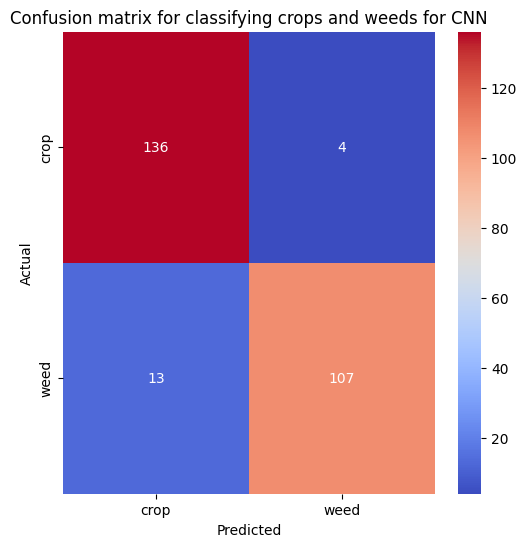

In [ ]:
#Plot the confusion matrix values using a heatmap for better accessibility and understanding
plt.figure(figsize = (6,6))
sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'coolwarm', xticklabels = ['crop', 'weed'], yticklabels = ['crop', 'weed'])
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.title("Confusion matrix for classifying crops and weeds for CNN")
plt.show()

#Plot training and validation accuracy

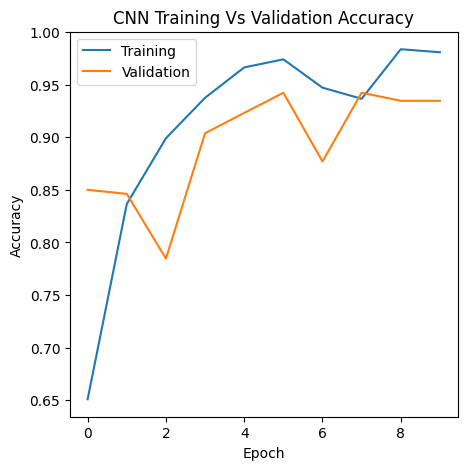

In [ ]:
plt.figure(figsize = (5,5))
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title("CNN Training Vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Training', 'Validation'], loc = 'upper left')
plt.show()

As observed from the above plot, the training accurcay increases exponentially with increase in epochs, whereas the validation accuracy has some fluctuations during the increase in epochs.

#Plot training and validation loss

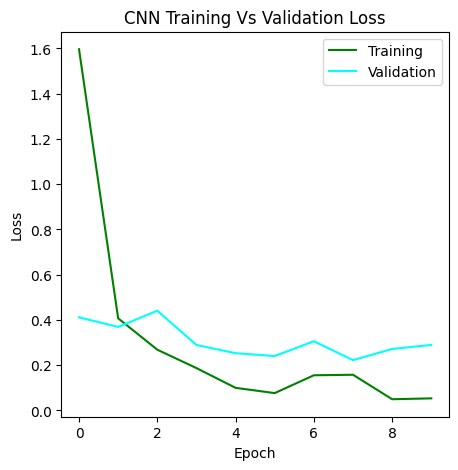

In [ ]:
plt.figure(figsize = (5,5))
plt.plot(cnn_history.history['loss'], color='green')
plt.plot(cnn_history.history['val_loss'], color = 'cyan')
plt.title("CNN Training Vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

As observed from the above plot, the training loss is decreasing exponentially with increase in the number of epochs, whereas the validation loss is also reducing slightly with increase in number of epochs.

##Model summary
Overall, the CNN model is performing quite well with accuracy greater than 90% and is also maintaing a balance between the falsely predicted and correctly predicted values.

#Save the CNN model

In [ ]:
cnn_model.save("C:/Users/Varnika Mulay/Downloads/cnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#**Crop and Weed classification using ResNet50 model**

#Load the saved CNN model

In [ ]:
from tensorflow.keras.models import load_model
cnn_model = load_model("C:/Users/Varnika Mulay/Downloads/cnn_model.h5")

#Define and compile the ResNet50 model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

'''Load the ResNet50 model without the top layers as we're using the pre-trained model based on the ImageNet dataset
which has been trained on millions of images and has 1000's of classes which are not required for our classification task.'''
resnet_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

#Freeze the base model
for layers in resnet_base.layers:
    layers.trainable = False
'''By setting layer.trainable = False, you prevent the weights of the pre-trained layers from being updated during training.
This allows you to retain the learned features from ImageNet while adding new layers on top that are specific to your classification task.'''

#Add custom layers on top of the base model created
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation = 'sigmoid')(x)

#Create the final ResNet50 model
resnet_model = Model(inputs = resnet_base.input, outputs = predictions)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
#Compile the model
resnet_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

#ResNet50 model training

In [ ]:
resnet_history = resnet_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 32)

Epoch 1/10
33/33 [==============================] - 17s 287ms/step - loss: 0.9425 - accuracy: 0.5231 - val_loss: 0.6348 - val_accuracy: 0.5385
Epoch 2/10
33/33 [==============================] - 5s 146ms/step - loss: 0.6673 - accuracy: 0.5913 - val_loss: 0.6831 - val_accuracy: 0.5308
Epoch 3/10
33/33 [==============================] - 5s 157ms/step - loss: 0.6151 - accuracy: 0.6663 - val_loss: 0.5544 - val_accuracy: 0.7500
Epoch 4/10
33/33 [==============================] - 5s 162ms/step - loss: 0.5627 - accuracy: 0.7163 - val_loss: 0.5223 - val_accuracy: 0.8231
Epoch 5/10
33/33 [==============================] - 5s 158ms/step - loss: 0.5266 - accuracy: 0.7577 - val_loss: 0.4950 - val_accuracy: 0.8308
Epoch 6/10
33/33 [==============================] - 5s 160ms/step - loss: 0.4850 - accuracy: 0.7904 - val_loss: 0.5207 - val_accuracy: 0.7115
Epoch 7/10
33/33 [==============================] - 5s 154ms/step - loss: 0.4994 - accuracy: 0.7683 - val_loss: 0.4483 - val_accuracy: 0.8538
Epoch

#Model evaluation

In [ ]:
#Evaluate the model performance on the validation data and get the val loss and accuracy values
val_loss, val_accuracy = resnet_model.evaluate(X_val, y_val)
print("Validation loss for ResNet50 model: ", val_loss * 100)
print("Validation accuracy for ResNet50 model: ", val_accuracy * 100)

9/9 [==============================] - 1s 110ms/step - loss: 0.5144 - accuracy: 0.6962
Validation loss for ResNet50 model:  51.44219994544983
Validation accuracy for ResNet50 model:  69.61538195610046


The above output suggests that the model is getting a validation accuracy of almost 70% and a validation loss of 51% which proves that this model is not performing very well.

In [ ]:
# Access training loss and accuracy
resnet_training_loss = resnet_history.history['loss'][-1]
resnet_training_accuracy = resnet_history.history['accuracy'][-1]

# Print or use these values
print("Training Loss for ResNet50 model:", resnet_training_loss*100)
print("Training Accuracy for ResNet50 model:", resnet_training_accuracy*100)

Training Loss for ResNet50 model: 44.89435851573944
Training Accuracy for ResNet50 model: 81.82692527770996


The training accuracy is coming to be 82% which is good but it has a very high loss value of about 50% which makes the model less efficient for our task.

#Generate classification report for ResNet50 model

In [ ]:
#Make predictions for the validation data
y_pred_resnet = resnet_model.predict(X_val)
y_pred_resnet = np.round(y_pred_resnet).flatten()

from sklearn.metrics import classification_report
resnet_report = classification_report(y_val, y_pred_resnet, target_names = ['crop', 'weed'])
print(resnet_report)

9/9 [==============================] - 2s 117ms/step
              precision    recall  f1-score   support

        crop       0.93      0.47      0.63       140
        weed       0.61      0.96      0.74       120

    accuracy                           0.70       260
   macro avg       0.77      0.71      0.68       260
weighted avg       0.78      0.70      0.68       260



In the above code we use flatten() function to ensure that the predicted values are in a one-dimensional array format. This step is necessary as the evaluation metrics like classification report require the input as a 1-D array.

#Display confusion matrix for ResNet50 model

In [ ]:
from sklearn.metrics import confusion_matrix

#generate the confusion matrix for the model
resnet_matrix = confusion_matrix(y_val, y_pred_resnet)
resnet_matrix

array([[ 66,  74],
       [  5, 115]])

Class 0 - weed and Class 1 - crop
#The above confusion matrix represents:
- 66 (True Negatives - TN): The model correctly predicted 66 weed images as weed.
- 74 (False Positives - FP): The model incorrectly predicted 74 weed images as crop.
- 5 (False Negatives - FN): The model incorrectly predicted 5 crop images as weed.
- 115 (True Positives - TP): The model correctly predicted 115 crop images as crop.

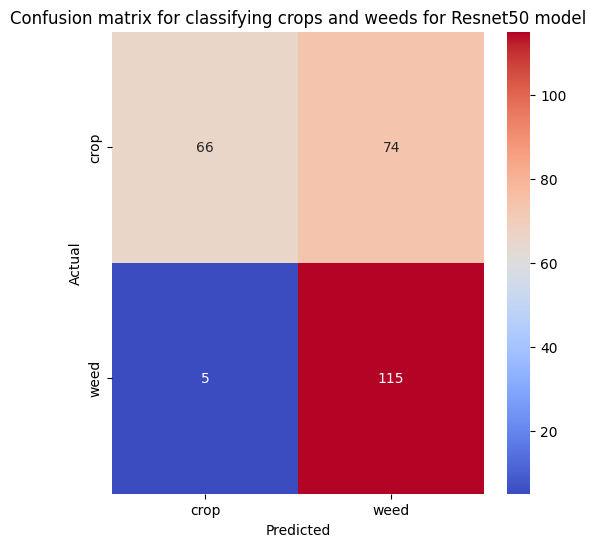

In [ ]:
#Plot the confusion matrix values using a heatmap for better accessibility and understanding
plt.figure(figsize = (6,6))
sns.heatmap(resnet_matrix, annot = True, fmt = 'd', cmap = 'coolwarm', xticklabels = ['crop', 'weed'], yticklabels = ['crop', 'weed'])
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.title("Confusion matrix for classifying crops and weeds for Resnet50 model")
plt.show()

#Saving the ResNet50 model

In [ ]:
resnet_model.save("C:/Users/Varnika Mulay/Downloads/resnet_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Visually plotting the model performance

Plotting and comparing the training and validation accuracies of ResNet50 model.

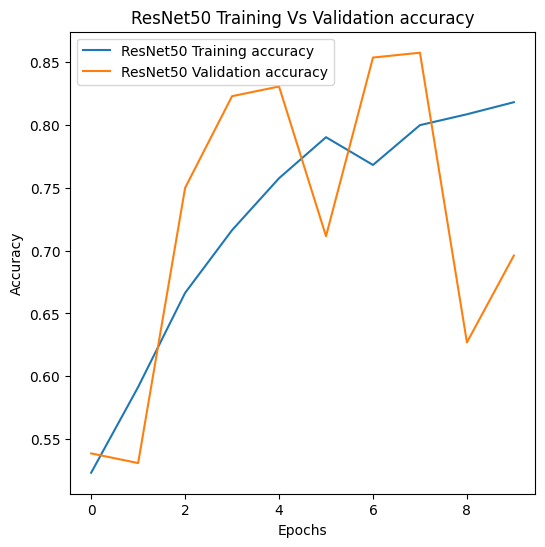

In [ ]:
plt.figure(figsize = (6,6))
plt.plot(resnet_history.history['accuracy'], label = 'ResNet50 Training accuracy')
plt.plot(resnet_history.history['val_accuracy'], label = 'ResNet50 Validation accuracy')
plt.title("ResNet50 Training Vs Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Plotting and comparing the training and validation loss of the ResNet50 model.

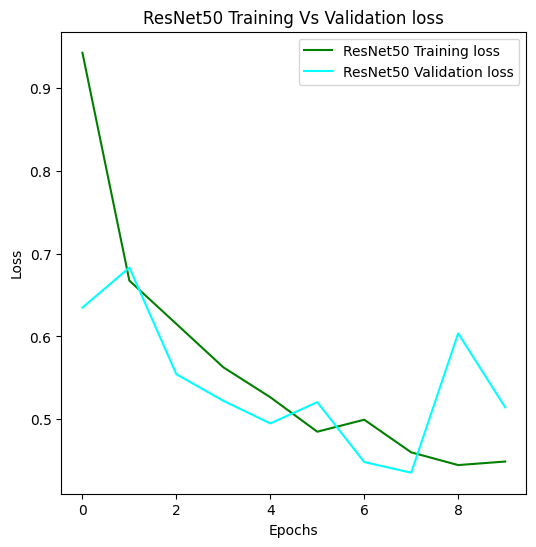

In [ ]:
plt.figure(figsize = (6,6))
plt.plot(resnet_history.history['loss'], label = 'ResNet50 Training loss', color = 'green')
plt.plot(resnet_history.history['val_loss'], label = 'ResNet50 Validation loss', color = 'cyan')
plt.title("ResNet50 Training Vs Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Comparing the CNN and ResNet50 model performance.

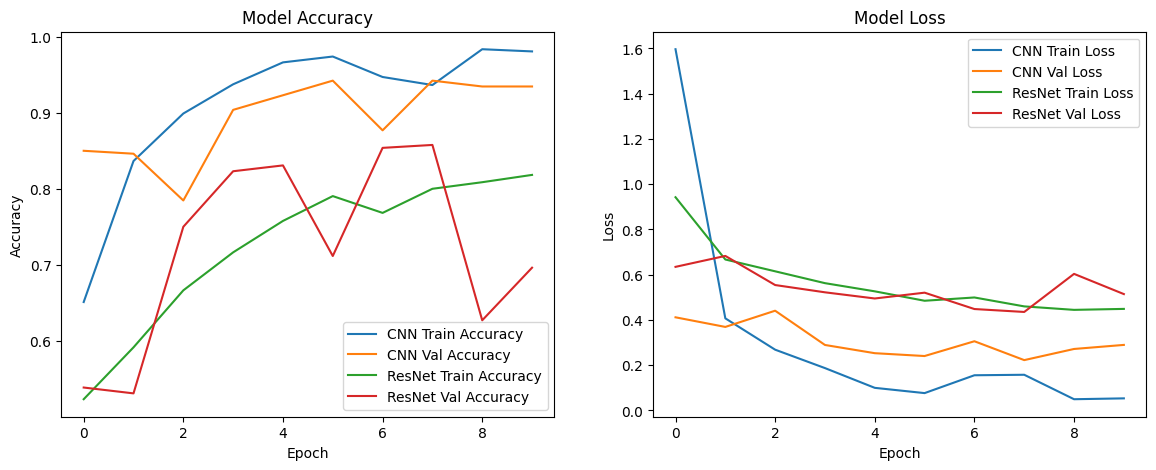

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val Accuracy')
plt.plot(resnet_history.history['accuracy'], label='ResNet Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Val Loss')
plt.plot(resnet_history.history['loss'], label='ResNet Train Loss')
plt.plot(resnet_history.history['val_loss'], label='ResNet Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



**CNN Model**:

- The training accuracy of the CNN model increases rapidly, reaching near 100% by epoch 10.
The validation accuracy for the CNN model is more stable and remains around 90% after epoch 5, with slight fluctuations.
Loss:

- The training loss of the CNN model decreases rapidly and continues to decrease steadily, indicating effective learning on the training data.
The validation loss of the CNN model decreases initially and then stabilizes at a low value, indicating good generalization to the validation data.

**ResNet Model**:
- The training accuracy of the ResNet model increases steadily, reaching around 80% by epoch 10.
The validation accuracy for the ResNet model is more variable but generally stabilizes around 80-85%, with noticeable fluctuations.
Loss:

- The training loss of the ResNet model decreases steadily but remains higher than that of the CNN model, suggesting slower learning.
The validation loss of the ResNet model is more variable, indicating potential issues with generalization and stability during training.

#**Ensemble Model - CNN + ResNet50 model**

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# Load the saved models
cnn_model = load_model("C:/Users/Varnika Mulay/Downloads/cnn_model.h5")
resnet_model = load_model("C:/Users/Varnika Mulay/Downloads/resnet_model.h5")

# Get predictions on training data
cnn_train_predictions = cnn_model.predict(X_train)
resnet_train_predictions = resnet_model.predict(X_train)

# Average the predictions
ensemble_train_predictions = (cnn_train_predictions + resnet_train_predictions) / 2

# Convert to binary labels
ensemble_train_predictions = (ensemble_train_predictions > 0.5).astype(int)

# Evaluate the ensemble model on training data
training_accuracy = accuracy_score(y_train, ensemble_train_predictions)
print(f'Ensemble Model Training Accuracy: {training_accuracy}')

# Get predictions on validation data
cnn_val_predictions = cnn_model.predict(X_val)
resnet_val_predictions = resnet_model.predict(X_val)

# Average the predictions
ensemble_val_predictions = (cnn_val_predictions + resnet_val_predictions) / 2

# Convert to binary labels
ensemble_val_predictions = (ensemble_val_predictions > 0.5).astype(int)

# Evaluate the ensemble model on validation data
validation_accuracy = accuracy_score(y_val, ensemble_val_predictions)
print(f'Ensemble Model Validation Accuracy: {validation_accuracy}')


33/33 [==============================] - 5s 120ms/step
Ensemble Model Training Accuracy: 0.9884615384615385
9/9 [==============================] - 1s 112ms/step
Ensemble Model Validation Accuracy: 0.9538461538461539


Observations for ensemble model

- The ensemble model has achieved a training accuracy of almost 99%, which is higher than the individual accuracies of your CNN and ResNet models.
- This improvement suggests that the ensemble model is better at generalizing to unseen data by leveraging the strengths of both models.